In [20]:
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import librosa

## Loading the dataset and createing train,val,test matrices

In [21]:
base_path = pathlib.Path("./ESC-50-master")
meta_data = pd.read_csv(base_path / "meta/esc50.csv")
audio_folder = base_path / "audio"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
meta_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [23]:
train_file_path_list=[]
val_file_path_list=[]
test_file_path_list=[]
y_train=[]
y_val=[]
y_test=[]
for file in audio_folder.iterdir():
    if file.name in meta_data[meta_data['esc10'] == True]['filename'].to_list():
        if file.name in meta_data[meta_data['fold'].isin([1,2,3]) ]['filename'].to_list():
            train_file_path_list.append(file)
            y_train.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
        elif file.name in meta_data[meta_data['fold'].isin([4]) ]['filename'].to_list():
            val_file_path_list.append(file)
            y_val.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
        elif file.name in meta_data[meta_data['fold'].isin([5]) ]['filename'].to_list():
            test_file_path_list.append(file)
            y_test.append(meta_data[meta_data['filename'] == file.name]['category'].values[0])
print("Train files: ", len(train_file_path_list))
print("Validation files: ", len(val_file_path_list))
print("Test files: ", len(test_file_path_list))

Train files:  240
Validation files:  80
Test files:  80


In [24]:
def extract_mel_spectrogram(audio_path, n_mels=128, win_ms=25, hop_ms=10, duration=5, sr=44100):
    
    
    y, sr = librosa.load(audio_path, sr=None, duration=duration)
    win_length = int(win_ms * sr / 1000)
    hop_length = int(hop_ms * sr / 1000)
    
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        win_length=win_length,
        hop_length=hop_length,
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db[:,:500] # Dropping the last columns as advised


In [25]:
# Each array is of the shape no of sample ,128, 500
X_train = np.stack([extract_mel_spectrogram(file) for file in train_file_path_list], axis=0)
X_val = np.stack([extract_mel_spectrogram(file) for file in val_file_path_list], axis=0)
X_test = np.stack([extract_mel_spectrogram(file) for file in test_file_path_list], axis=0)

In [26]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()
y_train = LabelEncoder.fit_transform(y_train)
y_val = LabelEncoder.transform(y_val)
y_test = LabelEncoder.transform(y_test)

# Part a A batch size of 32 is used throughout

In [27]:
X_train = torch.tensor(X_train,).unsqueeze(1)
X_val = torch.tensor(X_val).unsqueeze(1)
X_test = torch.tensor(X_test).unsqueeze(1)
y_train ,y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

## Creating datasets and dataloaders
 #TODO Mention in report I have used Relu activation function except for output layer I have used 10 epochs

In [28]:
from torch.utils.data import Dataset, DataLoader
batch_size = 16
num_epochs = 10
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Creating Model and Trainer Class

In [29]:
class vanilla_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
        self.l1 = nn.LazyLinear(out_features=128)
        self.l2 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self,X):
        '''
        X is 16,1,128,500  batch,num_channels, height, width 
        '''
        h1 = self.conv1(X) # 16,16,126,498
        h1_pool = self.pool(h1) # 16,16,124,496
        z1 = torch.relu(h1_pool)  
        h2 = self.conv2(z1) # 16,16,122,494
        h2_pool = self.pool(h2) # 16,16,120,492
        z2 = torch.relu(h2_pool)
        z2_flat = z2.reshape(z2.shape[0], -1)
        h3 = self.l1(z2_flat)
        z3 = torch.relu(h3)
        h4 = self.l2(z3) # 16,10
        return h4

In [30]:
class Trainer:
    def __init__(self,model,train_dl,val_dl,test_dl,epochs,optimizer,device):
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.test_dl = test_dl
        self.epochs = epochs
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss()
        self.model.to(self.device)
        self.train_loss = []
        self.val_loss = []
    
    def evaluate_loss(self,dl):
        self.model.eval()
        loss = 0
        total_samples = 0
        with torch.no_grad():
            for xb,yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                loss = loss+ self.loss_fn(pred, yb).item()*len(yb)
                total_samples += len(yb)
        return loss/total_samples
    
    
    def train(self):
        self.train_loss.append(self.evaluate_loss(self.train_dl))
        self.val_loss.append(self.evaluate_loss(self.val_dl))
        tqdm.write(f"Initial Train Loss: {self.train_loss[-1]}, Validation Loss: {self.val_loss[-1]}")
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for xb,yb in self.train_dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(self.evaluate_loss(self.train_dl))
            self.val_loss.append(self.evaluate_loss(self.val_dl))    
    def plot_loss(self,title):
        plt.plot(self.train_loss, label='Training Loss',marker='*')
        plt.plot(self.val_loss, label='Validation Loss',marker='o')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.savefig(title + ".png")
        plt.show()
    
    def evaluate_accuracy(self,dl):
        self.model.eval()
        correct = 0
        total_samples = 0
        with torch.no_grad():
            for xb,yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                pred = self.model(xb)
                y_pred = torch.argmax(pred, dim=1)
                correct += (y_pred == yb).sum().item()
                total_samples += len(yb)
        return correct/total_samples


## Running the expertiments

/home/harshit/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Initial Train Loss: 3.604983901977539, Validation Loss: 3.6848212242126466


100%|██████████| 10/10 [02:22<00:00, 14.27s/it]


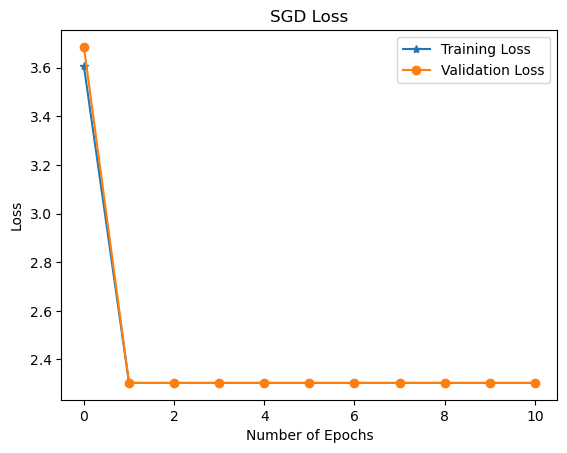

Train Accuracy with SGD: 0.1
Validation Accuracy with SGD: 0.1
Test Accuracy with SGD: 0.1


In [31]:
torch.manual_seed(0)
model_sgd = vanilla_cnn()
optimizer = optim.SGD(model_sgd.parameters())
trainer = Trainer(model_sgd,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("SGD Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with SGD: {train_accuracy}")
print(f"Validation Accuracy with SGD: {val_accuracy}")
print(f"Test Accuracy with SGD: {test_accuracy}")

In [32]:
del(trainer)
del(model_sgd)
del(optimizer)

In [33]:
torch.manual_seed(0)
model_sgd_momentum = vanilla_cnn()
optimizer = optim.SGD(model_sgd_momentum.parameters(), momentum=0.9)
trainer = Trainer(model_sgd_momentum,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("SGD with momentum")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with SGD with momentum: {train_accuracy}")
print(f"Validation Accuracy with SGD with momentum: {val_accuracy}")
print(f"Test Accuracy with SGD with momentum: {test_accuracy}")

Initial Train Loss: 3.604983901977539, Validation Loss: 3.6848212242126466


  0%|          | 0/10 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
del(trainer)
del(model_sgd_momentum)
del(optimizer)

In [ ]:
torch.manual.seed(0)
model_rmsprop = vanilla_cnn()
optimizer = optim.RMSprop(model_rmsprop.parameters())
trainer = Trainer(model_rmsprop,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("RMSprop Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with RMSprop: {train_accuracy}")
print(f"Validation Accuracy with RMSprop: {val_accuracy}")
print(f"Test Accuracy with RMSprop: {test_accuracy}")

In [ ]:
del(trainer)
del(model_rmsprop)
del(optimizer)

In [ ]:
torch.manual_seed(0)
model_adam = vanilla_cnn()
optimizer = optim.Adam(model_adam.parameters())
trainer = Trainer(model_adam,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Adam Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Adam: {train_accuracy}")
print(f"Validation Accuracy with Adam: {val_accuracy}")
print(f"Test Accuracy with Adam: {test_accuracy}")

In [ ]:
del(trainer)
del(model_adam)
del(optimizer)

# Part B

In [ ]:
class normed_cnn(nn.Module):
    def __init__(self,norm_type=None):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
        self.l1 = nn.LazyLinear(out_features=128)
        self.l2 = nn.Linear(in_features=128, out_features=10)
        self.norm_type = norm_type
        if norm_type == 'batch':
            self.norm_layer = nn.BatchNorm2d(16)
        elif norm_type == 'layer':
            self.norm_layer = nn.LayerNorm([120, 492])    
    def forward(self,X):
        '''
        X is 16,1,128,500  batch,num_channels, height, width 
        '''
        h1 = self.conv1(X) # 16,16,126,498
        h1_pool = self.pool(h1) # 16,16,124,496
        z1 = torch.relu(h1_pool)  
        h2 = self.conv2(z1) # 16,16,122,494
        h2_pool = self.pool(h2) # 16,16,120,492
        if self.norm_type is not None:
            h2_pool = self.norm_layer(h2_pool)
        z2 = torch.relu(h2_pool)
        z2_flat = z2.reshape(z2.shape[0], -1)
        h3 = self.l1(z2_flat)
        z3 = torch.relu(h3)
        h4 = self.l2(z3) # 16,10
        return h4

## Running the experiments for part b

In [ ]:
torch.manual_seed(0)
nonorm_model = normed_cnn(norm_type=None)
optimizer = optim.Adam(nonorm_model.parameters())
trainer = Trainer(nonorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("No Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with No Norm: {train_accuracy}")
print(f"Validation Accuracy with No Norm: {val_accuracy}")
print(f"Test Accuracy with No Norm: {test_accuracy}")
del(trainer)
del(nonorm_model)
del(optimizer)

In [ ]:
torch.manual_seed(0)
layernorm_model = normed_cnn(norm_type='layer')
optimizer = optim.Adam(layernorm_model.parameters())
trainer = Trainer(layernorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Layer Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Layer Norm: {train_accuracy}")
print(f"Validation Accuracy with Layer Norm: {val_accuracy}")
print(f"Test Accuracy with Layer Norm: {test_accuracy}")
del(trainer)
del(layernorm_model)
del(optimizer)

In [ ]:
torch.manual_seed(0)
batchnorm_model = normed_cnn(norm_type='batch')
optimizer = optim.Adam(batchnorm_model.parameters())
trainer = Trainer(batchnorm_model,train_dl,val_dl,test_dl,epochs=num_epochs,optimizer=optimizer,device=device)
trainer.train()
trainer.plot_loss("Batch Norm Loss")
train_accuracy = trainer.evaluate_accuracy(train_dl)
val_accuracy = trainer.evaluate_accuracy(val_dl)
test_accuracy = trainer.evaluate_accuracy(test_dl)
print(f"Train Accuracy with Batch Norm: {train_accuracy}")
print(f"Validation Accuracy with Batch Norm: {val_accuracy}")
print(f"Test Accuracy with Batch Norm: {test_accuracy}")
del(trainer)
del(batchnorm_model)
del(optimizer)